In [1]:
import os

In [2]:
# 整理dataset
dataset_path = '../autodl-tmp/kaggle_datasets/train/'
train_dataset_path = '../autodl-tmp/kaggle_datasets/train/'
test_dataset_path = '../autodl-tmp/kaggle_datasets/test/'
train_cat_path = train_dataset_path + 'cat/'
train_dog_path = train_dataset_path + 'dog/'
test_cat_path = test_dataset_path + 'cat/'
test_dog_path = test_dataset_path + 'cat/'

origin_files = os.listdir(dataset_path)
for file in origin_files:
    if os.path.isdir(file):
        continue
    oldfile_path = dataset_path + file
    (file_name, file_ext) = os.path.splitext(file)
    columns = file_name.split('.')
    if len(columns) != 2:
        continue
    label = columns[0]
    index = columns[1]
    index = int(index)
    new_filename = str(index) + file_ext
    if index < 10000:
        if label == 'cat':
            newfile_path = train_cat_path + new_filename
        else:
            newfile_path = train_dog_path + new_filename
    else:
        if label == 'cat':
            newfile_path = test_cat_path + new_filename
        else:
            newfile_path = test_dog_path + new_filename
    os.replace(oldfile_path, newfile_path)

print('Preprocess datasets Done!')

Preprocess datasets Done!


In [3]:
from torchvision import transforms, datasets

#定义transforms
transforms = transforms.Compose(
[
transforms.RandomResizedCrop(150),
transforms.ToTensor(),
transforms.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])
]
)

train_data = datasets.ImageFolder(train_dataset_path, transforms)
test_data=datasets.ImageFolder(test_dataset_path, transforms)

In [4]:
print('train dataset size: {}'.format(len(train_data)))
print('test dataset size: {}'.format(len(test_data)))
print('the first train dataset sample tensor shape: {}'.format(train_data[0][0].shape))
print('the first train dataset sample label: {}'.format(train_data[0][1]))

train dataset size: 20000
test dataset size: 5000
the first train dataset sample tensor shape: torch.Size([3, 150, 150])
the first train dataset sample label: 0


In [5]:
import torch

def dataset_split(full_dateset, train_rate): # full_ds为train_ds, train_rate=0.8
    train_size = int(len(full_dateset) * train_rate)
    validate_size = len(full_dateset) - train_size
    train_dataset, validate_dataset = torch.utils.data.random_split(full_dateset, [train_size, validate_size])
    return train_dataset, validate_dataset

def dataloader(dataset, batch_size, num_workers):
    data_loader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True, pin_memory=True, num_workers=num_workers)
    return data_loader

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCH = 30
LR = 0.001
TRAIN_RATE = 0.8
NUM_WORKERS = 14 # cpu cores num
BATCH_SIZE = 1500


In [7]:
train_data, valid_data = dataset_split(train_data, TRAIN_RATE)
print('train dataset size: {}'.format(len(train_data)))
print('valid dataset size: {}'.format(len(valid_data)))
train_dataloader = dataloader(train_data, BATCH_SIZE, NUM_WORKERS)
valid_dataloader = dataloader(valid_data, BATCH_SIZE, NUM_WORKERS)
test_dataloader = dataloader(test_data, BATCH_SIZE, NUM_WORKERS)

for i, item in enumerate(train_dataloader):
    print(i)
    print(item[0].shape)  # (batchsize, channels, width, height)
    break

train dataset size: 16000
valid dataset size: 4000
0
torch.Size([1500, 3, 150, 150])


In [8]:
import torch.optim as optim
from torchvision import models
from torch import nn
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = nn.Linear(512, 2) # 将最后一层全连接的输出调整到2维
net = resnet18.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

/root/miniconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
# train
train_losses = []
train_counter = []
test_accuracy = [0.0]
test_counter = [i*len(train_dataloader.dataset) for i in range(EPOCH + 1)]

for epoch in range(0, EPOCH):
    # print('Epoch: %d' % (epoch + 1))
    net.train()
    sum_loss = 0.0
    correct = 0.0
    total = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # prepare dataset
        length = len(train_dataloader)
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        
        # forward & backward
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print ac & loss in each batch
        sum_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += predicted.eq(labels.data).cpu().sum()
        train_losses.append(sum_loss / (i + 1))
        train_counter.append((i*BATCH_SIZE) + (epoch*len(train_dataloader.dataset)))
    scheduler.step()
    print('[epoch:%d] <Train> Loss: %.03f, Acc: %.3f%% ' % (epoch + 1, sum_loss / (i + 1), 100. * correct / total), end='\t')
        
    # get the ac with testdataset in each epoch
    with torch.no_grad():
        correct = 0
        total = 0
        for data in valid_dataloader:
            net.eval()
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum()
        print('<Test> Acc: %.3f%%' % (100 * correct / total))
        test_accuracy.append(correct.item() / total)

print('Train has finished, total epoch is %d' % EPOCH)
torch.save(net.state_dict(), './' + str(EPOCH) +'epoch-model.pth')
torch.save(optimizer.state_dict(), './' + str(EPOCH) +'epoch-optimizer.pth')

[epoch:1] <Train> Loss: 0.580, Acc: 67.600% 	<Test> Acc: 87.850%
[epoch:2] <Train> Loss: 0.298, Acc: 88.144% 	<Test> Acc: 92.000%
[epoch:3] <Train> Loss: 0.207, Acc: 92.325% 	<Test> Acc: 92.675%
[epoch:4] <Train> Loss: 0.180, Acc: 92.762% 	<Test> Acc: 93.250%
[epoch:5] <Train> Loss: 0.163, Acc: 93.775% 	<Test> Acc: 93.875%
[epoch:6] <Train> Loss: 0.156, Acc: 93.700% 	<Test> Acc: 94.100%
[epoch:7] <Train> Loss: 0.148, Acc: 94.113% 	<Test> Acc: 94.650%
[epoch:8] <Train> Loss: 0.144, Acc: 94.275% 	<Test> Acc: 94.000%
[epoch:9] <Train> Loss: 0.141, Acc: 94.444% 	<Test> Acc: 94.800%
[epoch:10] <Train> Loss: 0.136, Acc: 94.369% 	<Test> Acc: 94.425%
[epoch:11] <Train> Loss: 0.131, Acc: 94.600% 	<Test> Acc: 94.600%
[epoch:12] <Train> Loss: 0.129, Acc: 94.800% 	<Test> Acc: 94.600%
[epoch:13] <Train> Loss: 0.128, Acc: 94.875% 	<Test> Acc: 95.000%
[epoch:14] <Train> Loss: 0.125, Acc: 95.000% 	<Test> Acc: 94.750%
[epoch:15] <Train> Loss: 0.124, Acc: 94.969% 	<Test> Acc: 95.025%
[epoch:16] <Train> 

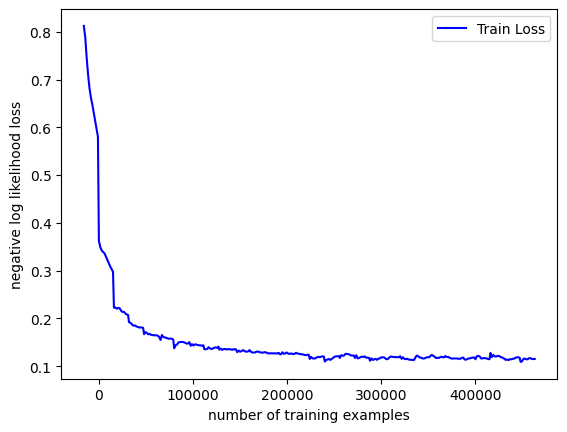

In [10]:
import matplotlib.pyplot as plt
fig1 = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.xlabel('number of training examples')
plt.ylabel('negative log likelihood loss')
plt.legend(['Train Loss'], loc='upper right')
fig1.show()

Text(0, 0.5, 'accuracy')

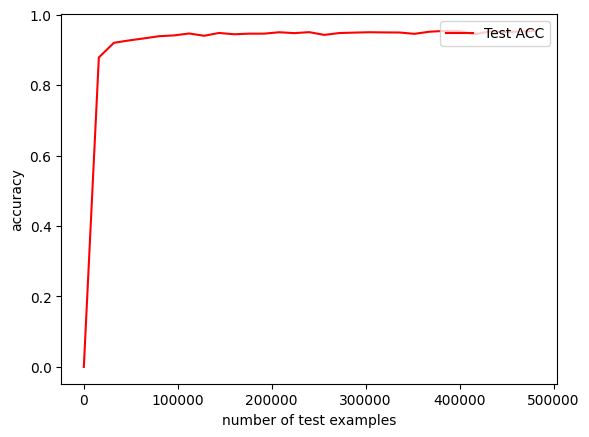

In [11]:
# print(test_counter)
# print(test_accuracy)
fig2 = plt.figure()
plt.plot(test_counter, test_accuracy, color='red')
plt.legend(['Test ACC'], loc='upper right')
plt.xlabel('number of test examples')
plt.ylabel('accuracy')